Задачей даннной работы является выявления преимуществ и недостатков следующих методов оптимизации нулевого и первого порядка:
Замечание:Описание метода предсатвляет сообой переход метода от состояния a к состоинию b ввиду итеративности всех представленных методов 
1) Градиентный спуск с фиксированным шагом. Описание метода: По исходной точке a и значению градиента функции в ней вычисляется точка b как a - grad(f) * learning_rate, где learning_rate - предварительно заданное значение, неизменное на протяжении всей 
2) Градиентный спуск с изменяющимся шагом на основе метода дихотомии. Описание метода:  По исходной точке a и значению градиента функции в ней вычисляется точка b как a - grad(f) * learning_rate1, где learning_rate - результат работы метода дихотомии на функции f(learning_rate1) = a - grad(f) * learning_rate1. Левой границей метода служит 0, правой -learning_rate, задаваемый для градиентного спуска. Вычисление останавливается при достижении заданной точности 
3) Градиентный спуск с изменяющимся шагом на основе метода золотого сечения. Описание метода: аналогичен п.2, за исключением того, что вместо метода дихотомии используется метод золотого сечения
Замечание: для большей стабильности методов 1-3 градиент (в формуле вычисления следующего значения) нормируется
4) Метод покоординатного спуска. Описание метода: Основываясь на исходной точке x и длине шага step_len Итеративно проверяется точка, получаемая из x прибавлением step_len к проверяемой координате. Если значение меньше, чем в x - происходит переход в данную точку, иначе проверяется значение в точке, получаемой из x вычитанием step_len из проверяемой координаты. Если значение в ней меньше, чем в x - происходит переход, иначе аналогичные проверки проводятся по следующей координате. Если перехода не произошло после проверки всех координат, значение step_len уменьшается
5) Метод Нелдера-Мида. Описание метода: У метода есть параметры альфа (коэффициент отражения), бета(коэффициент сжатия) и гамма (коэффициент растяжения), которые должны быть больше 0 и обычно равны 1, 0.5, 2 соответственно.
Выбираем n + 1 точку, которые образуют n-мерный тетраэдр. Вычисляем значения в этих точках. Дальше сортируем вершины по возрастанию значения функции. Из них выбираем три точки: xh с наибольшим (из выбранных) значением функции fh, xg со следующим по величине значением fg и xl с наименьшим значением функции fl. Далее находим центр тяжести точек, кроме 2: xh и xc = 1/n * (сумма по  i != h xi) . Отразим точку xh отностиельно xc. И просто смотрим какое место занимает fr среди fh, fg, fl. В зависимости от места меняем значение x-ов. И заканчиваем итерацию. Чтобы алгоритм закончился требуются, чтобы была достигнута взаимная близость вершин симплекса с заданной точностью (это равносильно проверки на близость к минимуму).

In [1]:
%matplotlib widget
from src.tests.tester import Tester
from src.lab1.methods import NMMethod
from src.lab1.method_processor import MethodProcessor
from src.metric import CallCount, GradientCount, PrecisionCount, AbsolutePrecisionCount
from src.common.oracul import LambdaOracul, PoweredSumOracul, GradientLambdaOracul, MultiGradientLambdaOracul

from src.lab1.stop_condition import CountCondition, PrecisionCondition, AndCondition, OrCondition
import numpy as np
from src.common import Oracul, Point
from src.lab1.method_processor import MethodProcessor
from src.lab1.methods import GoldenRatioMethod, GradientDescent, BaseGradientDescent, DichotomyMethod, \
    CoordinateDescent
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

nm_3 = NMMethod(0.001)
nm_2 = NMMethod(0.01)
nm_1 = NMMethod(0.1)
coordinate_descent_1 = CoordinateDescent(eps=0.1)
coordinate_descent_2 = CoordinateDescent(eps=0.01)
coordinate_descent_3 = CoordinateDescent(eps=0.001)


In [2]:
golden_ratio = GoldenRatioMethod()
gradient_descent_fix = BaseGradientDescent()
gradient_descent_golden = GradientDescent()
gradient_descent_dichotomy = GradientDescent(method=DichotomyMethod())
gradient_descent_golden_2 = GradientDescent(aprox_dec=0.01)
gradient_descent_dichotomy_2 = GradientDescent(method=DichotomyMethod(), aprox_dec=0.01)
gradient_descent_golden_1 = GradientDescent(aprox_dec=0.1)
gradient_descent_dichotomy_1 = GradientDescent(method=DichotomyMethod(), aprox_dec=0.1)
oracul = LambdaOracul(lambda x: (x - 10) ** 2)
gradient_oracul = GradientLambdaOracul(lambda x, y: (x - 10) ** 2 + (y - 5) ** 2,
                                       lambda x, y: np.array([2 * (x - 10), 2 * (y - 5)], dtype=np.float64))

In [3]:
base_test = GradientLambdaOracul(lambda x, y: x ** 2 + y ** 2,
                                 lambda x, y: np.array([2 * x, 2 * y], dtype=np.float64))
base_differential = GradientLambdaOracul(lambda x, y: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y,
                                         lambda x, y: np.array([0.52 * x - 0.48 * y, 0.52 * y - 0.48 * x],
                                                               dtype=np.float64))
bad_defined_base = GradientLambdaOracul(lambda x, y: 100 * x ** 2 + y ** 2,
                                        lambda x, y: np.array([200 * x, 2 * y], dtype=np.float64))

In [4]:
abs_prec_1 = AbsolutePrecisionCount(Point([0, 0, 0]), 0.1)
abs_prec_2 = AbsolutePrecisionCount(Point([0, 0, 0]), 0.01)
abs_prec_3 = AbsolutePrecisionCount(Point([0, 0, 0]), 0.001)

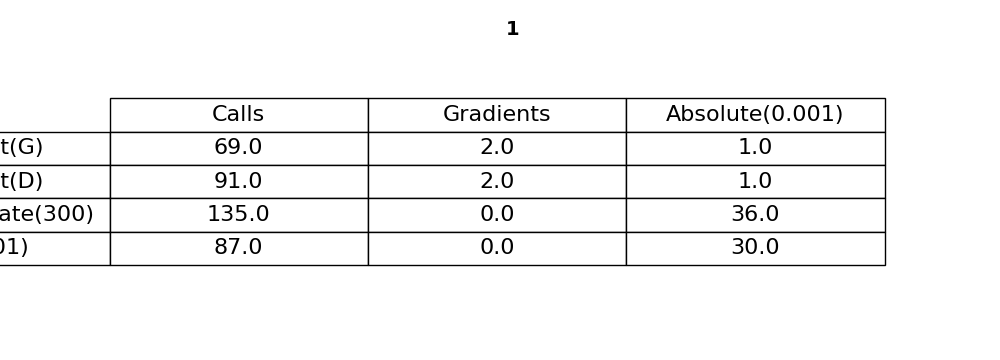

[[Point(coordinates=array([2.05303102e-05, 4.10606204e-05, 2.10746819e-09])),
  Point(coordinates=array([-1.21306236e-05, -2.42612472e-05,  7.35760144e-10])),
  Point(coordinates=array([ 3.81469727e-04, -3.81469727e-04,  2.91038305e-07])),
  Point(coordinates=[0.2084490843117237, 0.003098994493484497, 0.04346062451726675])]]

In [5]:
Tester.test([gradient_descent_golden, gradient_descent_dichotomy, coordinate_descent_3, nm_3],
            [base_test], [CallCount(), GradientCount(), abs_prec_3],
            PrecisionCondition(0.001),
            start_point=[100, 200])  #turn on visualization  to demonstration

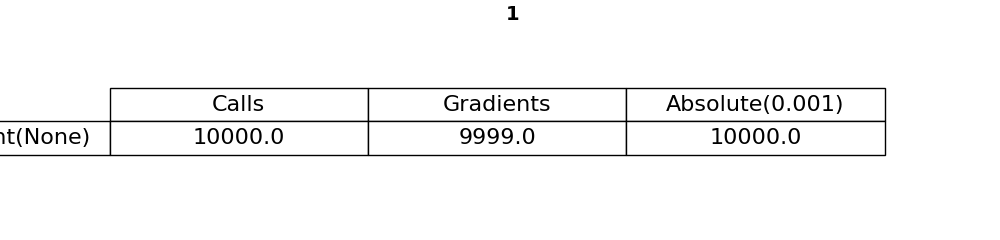

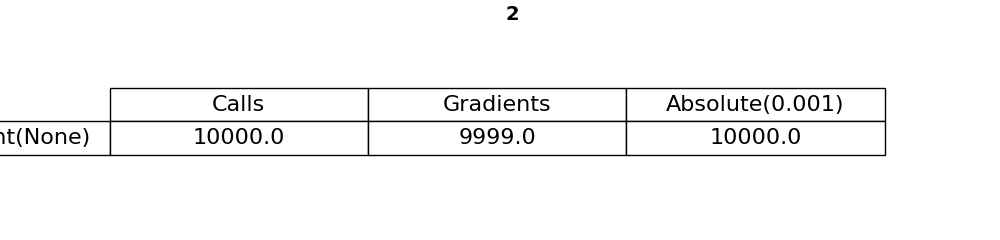

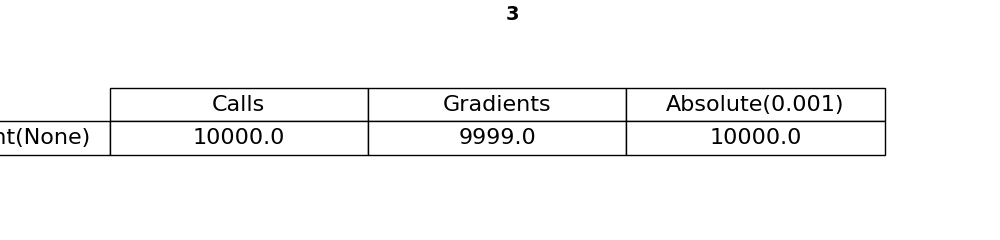

[[Point(coordinates=array([-0.04168131, -0.08336263,  0.00868666]))],
 [Point(coordinates=array([3.86964528e-02, 3.86964528e-02, 5.98966185e-05]))],
 [Point(coordinates=array([ 5.17021769e-003, -9.88131292e-324,  2.67311510e-003]))]]

In [6]:
Tester.test([BaseGradientDescent()], [base_test, base_differential, bad_defined_base],
            [CallCount(), GradientCount(), abs_prec_3], CountCondition(max_count=10 ** 4), learning_rate=0.1,
            start_point=[100, 200])

Замечание: Здесь и далее под методами градиентного спуска понимаются методы на основе градиентного спуска с нефиксированным шагом
Первый тест позволяет обнаружить следубщие особенности методов:
1) Как наиболее явное отличие, методы покоординатного спуска и Нелдера-Мида не требуют вычисления градиента, что является весьма значительной особенностью и выгодно выделяет их на фоне методов градиетного спуска
2) Метод градиетного спуска с фиксированным шагом, хотя и требует вычисления значений функции при данной постановке задачи, не столь сильно в ней нуждается, используя лишь для проверки приближения (как можно заметить, число шагов метода равно числу вычислений значений). Однако едва ли данное преимущество способно перекрыть такие недостатки метода, как отсутствие гарнтии сходимости и потребность в тонкой настройке параметров для обеспечения приемлимой точности или минимальной работоспособности, кроме того число вычислений градиента отличается на порядки ввиду необходимости выставления достаточно малого шага для получения приемлимой точности, кроме того возможны попадания в циклы
3) Хотя методы градиентного спуска и требуют несколько большего числа вычислений значений функции (в основном из-за необходимости вычисления шага с достаточной точностью), число их итераций для достижения искомой точности меньше, чем требуемое для покоординатного спуска и Нелдера-Мида
4) Метод градиентного спуска на основе дихотомии требует значительно большего числа вычисления значений функций, что является ожидаемым следствием меньшей вычислительной эффективности внутреннего метода

Точность 0.01

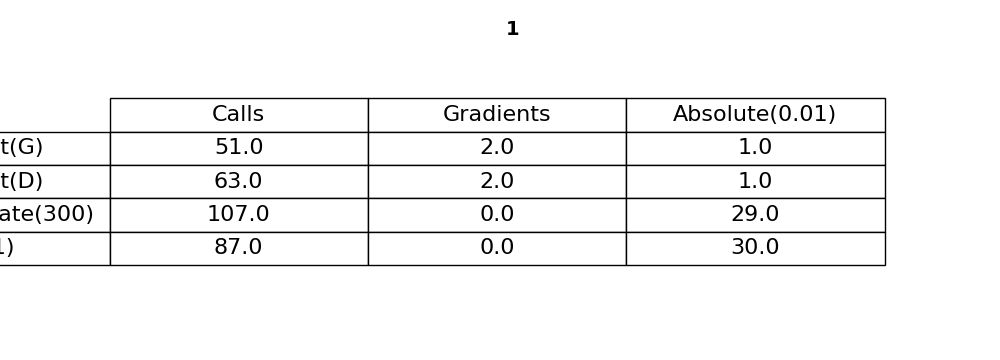

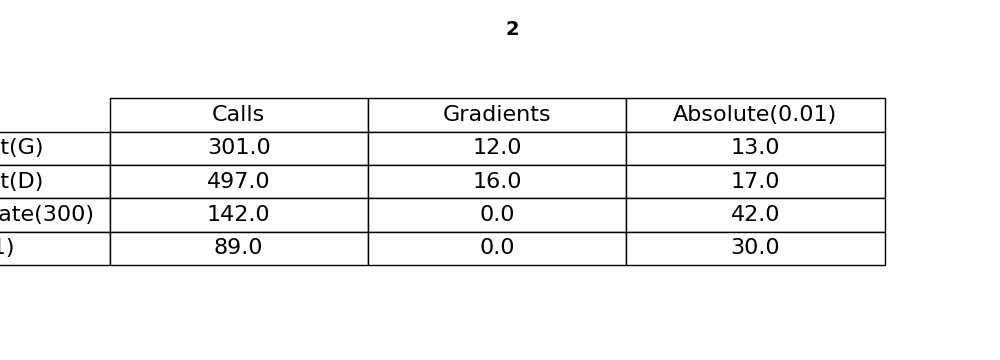

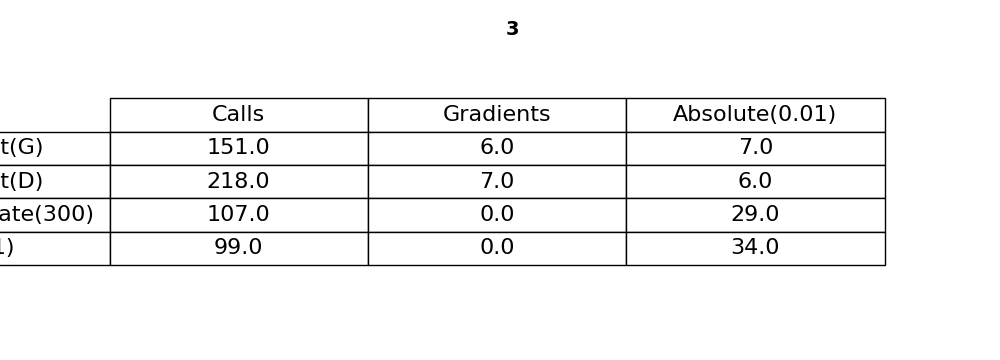

[[Point(coordinates=array([-1.12924171e-03, -2.25848343e-03,  6.37593424e-06])),
  Point(coordinates=array([-7.15849222e-04, -1.43169844e-03,  2.56220054e-06])),
  Point(coordinates=array([ 6.10351562e-03, -6.10351562e-03,  7.45058060e-05])),
  Point(coordinates=[0.2084490843117237, 0.003098994493484497, 0.04346062451726675])],
 [Point(coordinates=array([2.98896808e-02, 3.40890073e-02, 4.53413112e-05])),
  Point(coordinates=array([0.05688377, 0.05956115, 0.00013739])),
  Point(coordinates=array([2.44140625e-02, 3.05175781e-02, 3.94880772e-05])),
  Point(coordinates=[-0.03599001909606159, 0.09701996110379696, 0.004460160246406366])],
 [Point(coordinates=array([-0.00273858,  0.03061871,  0.00168748])),
  Point(coordinates=array([6.11020851e-04, 3.89126596e-03, 5.24765988e-05])),
  Point(coordinates=array([ 0.00610352, -0.00610352,  0.00376254])),
  Point(coordinates=[0.0043273065239191055, -0.23204704280942678, 0.05571838825179523])]]

In [7]:
Tester.test([gradient_descent_golden_2, gradient_descent_dichotomy_2, coordinate_descent_2, nm_2],
            [base_test, base_differential, bad_defined_base], [CallCount(), GradientCount(), abs_prec_2],
            PrecisionCondition(0.01), start_point=[100, 200])

Точность 0.1

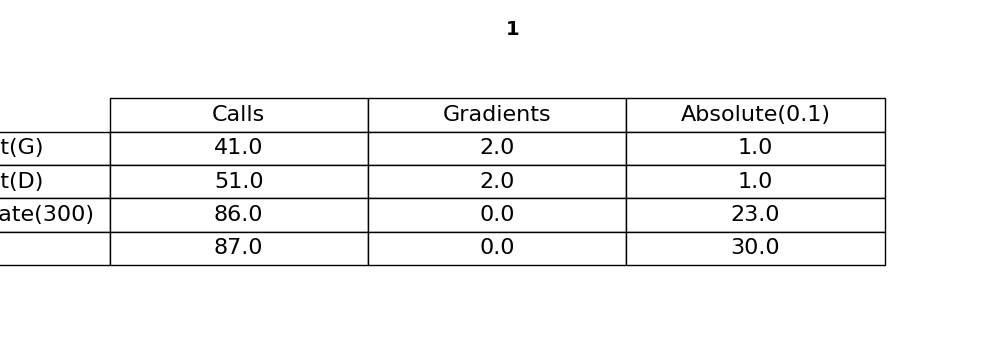

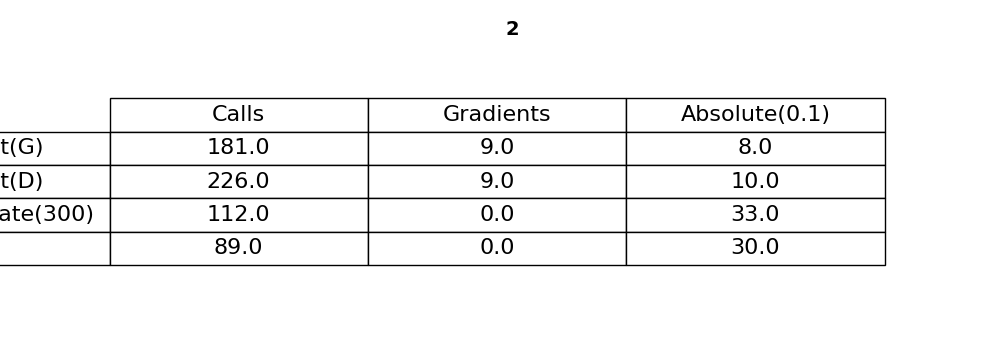

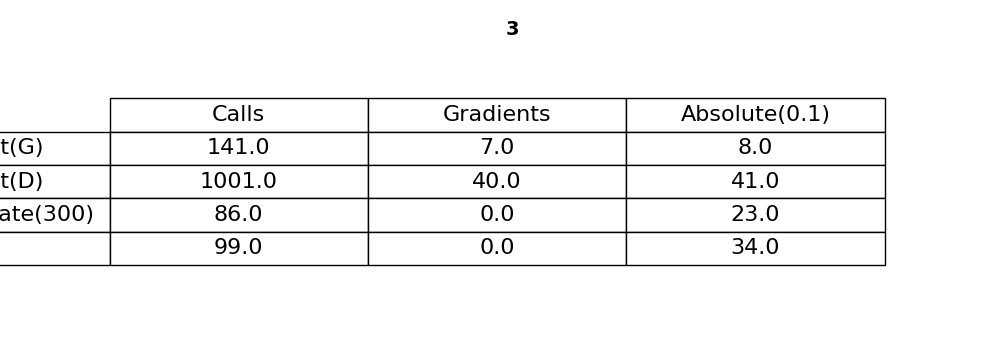

[[Point(coordinates=array([-0.01547988, -0.03095975,  0.00119813])),
  Point(coordinates=array([-7.15849222e-04, -1.43169844e-03,  2.56220054e-06])),
  Point(coordinates=array([-0.04882812,  0.04882812,  0.00476837])),
  Point(coordinates=[0.2084490843117237, 0.003098994493484497, 0.04346062451726675])],
 [Point(coordinates=array([-1.96934881e-02, -5.78316481e-04,  9.54569076e-05])),
  Point(coordinates=array([0.38528515, 0.40674333, 0.0063882 ])),
  Point(coordinates=array([0.24414062, 0.1953125 , 0.00252724])),
  Point(coordinates=[-0.03599001909606159, 0.09701996110379696, 0.004460160246406366])],
 [Point(coordinates=array([0.01221139, 3.12722992, 9.7944788 ])),
  Point(coordinates=array([0.01570476, 2.71359193, 7.38824512])),
  Point(coordinates=array([-0.04882812,  0.04882812,  0.24080276])),
  Point(coordinates=[0.0043273065239191055, -0.23204704280942678, 0.05571838825179523])]]

In [8]:
Tester.test([gradient_descent_golden_1, gradient_descent_dichotomy_1, coordinate_descent_1, nm_1],
            [base_test, base_differential, bad_defined_base], [CallCount(), GradientCount(), abs_prec_1],
            PrecisionCondition(0.1), start_point=[100, 200])

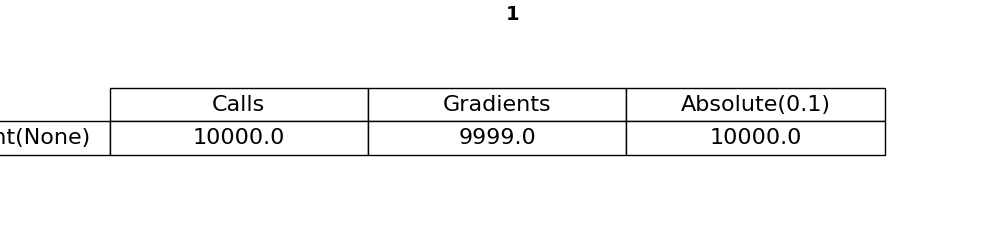

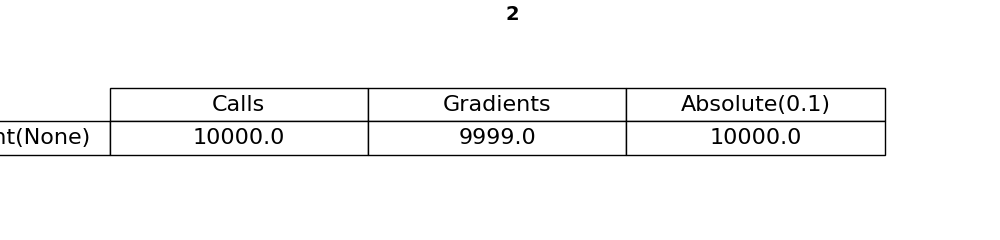

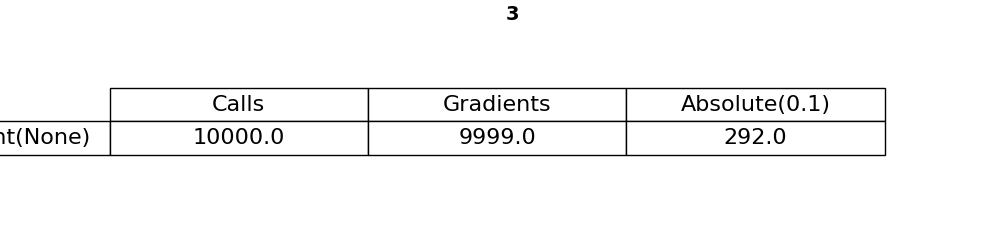

[[Point(coordinates=array([0.2713682 , 0.54273641, 0.36820351]))],
 [Point(coordinates=array([-0.27707295, -0.27707295,  0.00307078]))],
 [Point(coordinates=array([ 5.65335658e-01, -3.02563632e-88,  3.19604406e+01]))]]

In [10]:
Tester.test([BaseGradientDescent()], [base_test, base_differential, bad_defined_base],
            [CallCount(), GradientCount(), abs_prec_1], CountCondition(max_count=10 ** 4), learning_rate=1,
            start_point=[100, 200])
#test_fix_grad([base_test, base_differential, bad_defined_base], [0.101, 0.1001, 0.101], eps=0.1, visualize=False)

Таким образом, при понижении точности, общие тенденции сохраняются, хотя и уменьшается разница в абсолютных значениях.
Тем не менее, стоит обратить внимание на следующие особенности:
 1) понижение точности для градиентных методов означает не только уменьшение числа вычислений функции, но и её градиента
2) Благодаря особенностям работы методов, методы градиентного спуска, как правило, вычисляют значение с некоторым запасом точности, в отличие от метода покоординатного спуска
3) Хотя запрашиваемое приближение для внутренних методов градиентых спусков (дихотомии и золотого сечения) одинаково, можно заметить, что в двух тестах число итераций градиентного спуска на основе метода золотого сечения было меньшим. Вероятно, данная особенность связана с попаданием минимума в меньший из промежутков и, как следствие, вычисление с большей реальной точностью, при меньшем объёме вычислений. Хотя был и пример обратного
4) Использование метода градиентного спуска с фиксированным шагом на функции неизвестного вида с целью получения заданного приближения видится сомнительным
5) При уменьшении запрашиваемой точности применение метода градиентного спуска с фиксированным шагом видится более целесообразным, нежели при желании получить высокую точность, ведь хотя метод и входил в бесконечный цикл, будучи неспособным приблизиться к точке или понять ,что он уже достаточно близок, приближение происходило за разумное время

Изменённая точка старта

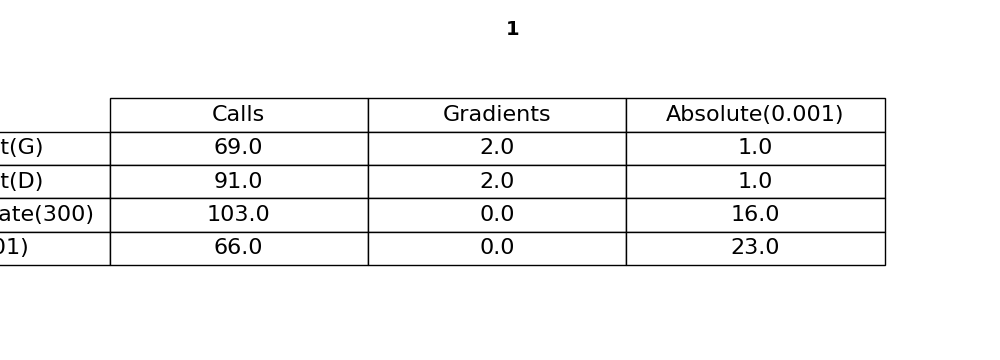

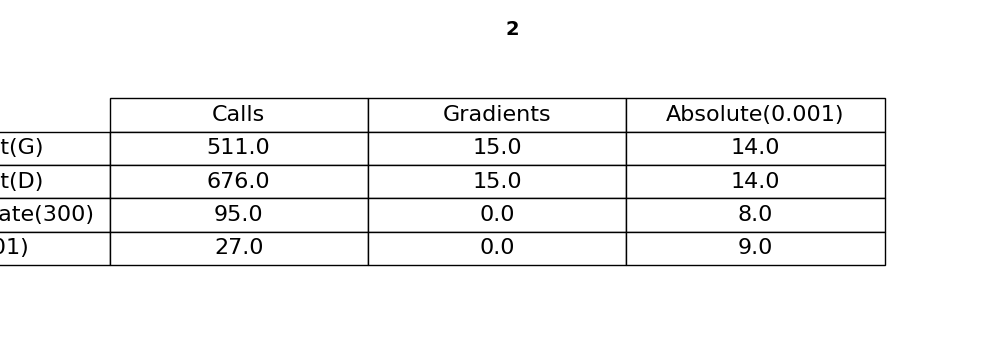

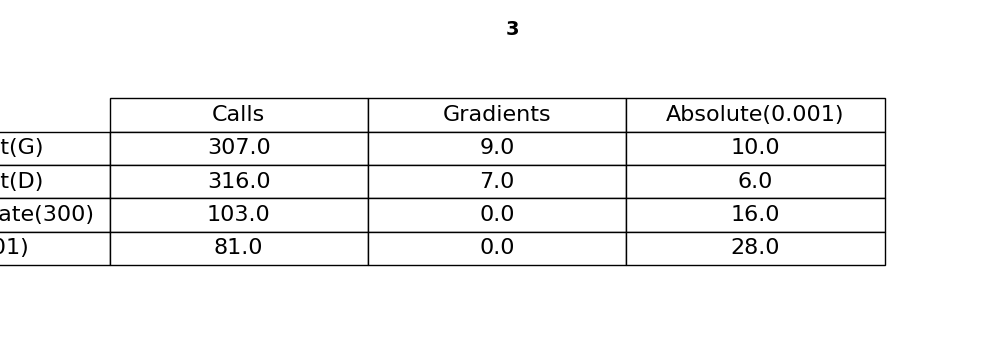

[[Point(coordinates=array([-2.02307770e-05, -4.04615541e-05,  2.04642170e-09])),
  Point(coordinates=array([-1.21306236e-06, -2.42612472e-06,  7.35760144e-12])),
  Point(coordinates=array([1.52587891e-04, 3.05175781e-04, 1.16415322e-07])),
  Point(coordinates=[0.330902099609375, -0.023681640625, 0.11005701962858438])],
 [Point(coordinates=array([2.57991871e-05, 2.12757818e-05, 2.72758257e-11])),
  Point(coordinates=array([6.74583504e-05, 8.93960398e-05, 3.66348551e-10])),
  Point(coordinates=array([1.52587891e-04, 3.05175781e-04, 7.91624188e-09])),
  Point(coordinates=[12.9375, 12.5, 6.518515625000006])],
 [Point(coordinates=array([-3.34063831e-05,  9.77396574e-03,  9.56420049e-05])),
  Point(coordinates=array([-1.93240793e-05,  5.49043676e-04,  3.38790962e-07])),
  Point(coordinates=array([1.52587891e-04, 3.05175781e-04, 2.42143869e-06])),
  Point(coordinates=[-0.017409324645996094, 0.284212589263916, 0.11108525435906813])]]

In [11]:
Tester.test([gradient_descent_golden, gradient_descent_dichotomy, coordinate_descent_3, nm_3],
            [base_test, base_differential, bad_defined_base], [CallCount(), GradientCount(), abs_prec_3],
            PrecisionCondition(0.001), start_point=[10, 20])

В данном отчёте и представлен всего 1 пример смещения точки старта ввиду малой интересности рассмотрения данных случаев. Влияние выбора точки на работу метдов, за исключением, возможно, чуть большего или меньшего числа итераций для вычисления, замечено не было. Подобное достаточно легко объясняется тем, что с точки зрения алгоритма подобное эквивалетно изменению самой функции f(x, y) -> f(x + a, y + b).
Перейдём к рассмотрению менее тривиальных функций. Тестирование метода градиентного спуска с фиксированным шагом далее производиться не будет ввиду очевидности после представленных выше примеров как куда меньшей вычислительной эффективности по сравнению с модификациями изменяемого шага, так и зависимости от тонкости настройки, что видится невозможным в реальных условиях, которые и призваны имитировать дальнейшие тесты

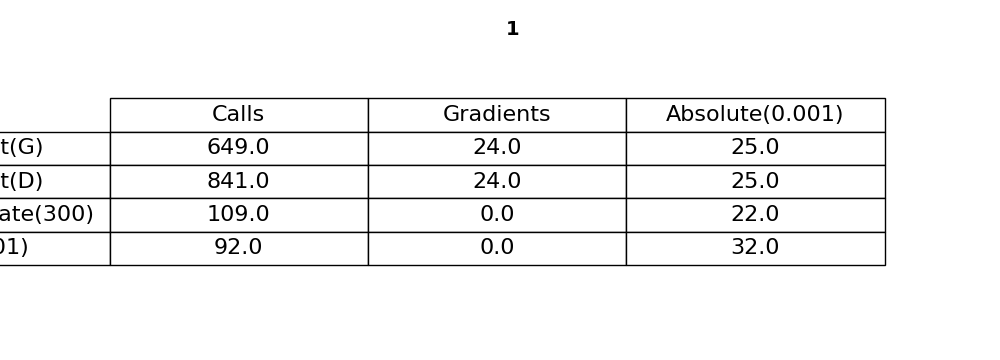

[[Point(coordinates=array([ 9.99996550e+00, -2.00000260e+01,  2.40167314e-42])),
  Point(coordinates=array([ 9.99995262e+00, -2.00000335e+01,  5.72292386e-41])),
  Point(coordinates=array([ 9.99946594e+00, -2.00004578e+01,  1.92787766e-30])),
  Point(coordinates=[9.789821412414312, -20.067488104104996, 0.00016822293204632116])]]

In [12]:
bad_defined = GradientLambdaOracul(lambda x, y: 1000 * (np.float64(x) - 10) ** 10 + 100 * (np.float64(y) + 20) ** 10,
                                   lambda x, y: np.array(
                                       [1000 * (np.float64(x) - 10) ** 9, 1000 * (np.float64(y) + 20) ** 9],
                                       dtype=np.float64))
isom_function = GradientLambdaOracul(
    lambda x, y: -np.cos(x) * np.cos(y) * np.exp(-((x - np.pi) ** 2 + (y - np.pi) ** 2)),
    lambda x, y: np.array(
        [np.exp(-(x - np.pi) ** 2 - (y - np.pi) ** 2) * np.cos(x) * np.cos(y) + 2 * (x - np.pi) * np.cos(x),
         np.exp(-(x - np.pi) ** 2 - (y - np.pi) ** 2) * np.cos(x) * np.cos(y) + 2 * (y - np.pi) * np.cos(y)],
        dtype=np.float64))
Tester.test([gradient_descent_golden, gradient_descent_dichotomy, coordinate_descent_3, nm_3],
            [bad_defined], [CallCount(), GradientCount(), abs_prec_3],
            PrecisionCondition(0.001), start_point=[-100, -200], learning_rate=10)

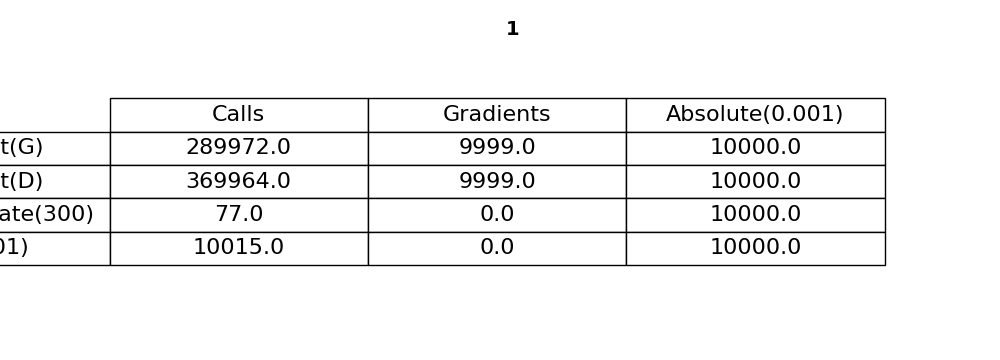

[[Point(coordinates=array([-85.85789043, -85.85789043,  -0.        ])),
  Point(coordinates=array([-85.85789135, -85.85789135,  -0.        ])),
  Point(coordinates=array([-100., -100.,   -0.])),
  Point(coordinates=[-100.0, -100.0, -0.0])]]

In [21]:
Tester.test([gradient_descent_golden, gradient_descent_dichotomy, coordinate_descent_3, nm_3],
            [isom_function], [CallCount(), GradientCount(), abs_prec_3],
            CountCondition(10000), start_point=[-100, -100], learning_rate=20)

Таким образом, все методы справляются с выполнением своих задач на плохо обусловленных функциях(по крайней мере, до тех пор, пока их значчения представляется возможным рассчитать), хотя и наиболее эффективен здесь метод покоординатного спуска. Т.к. значение функции меняется весьма значительно даже при небольшом отклонении, методам градиентного спуска приходится запрашивать значительное число значений. Так же примечательно то, что метод координатного спуска сделал меньшее число итераций
Примечателен итог работы методов на функции Изома. Методы Нелдера-Мида и покоординатного спуска не смогли справиться с поставленной задачей, градиентные же спуски, пусть и за не столь короткое время, всё же смогли приблизиться к минимуму, хотя и с небольшого расстояния (тесты запускались с запросом выполнения числа итераций ввиду неспособности методов в данном случае понять реальное приближение. Демонстрирующий это пример, ввиду своей очевидности, опущен для простоты восприятия остальной информации)

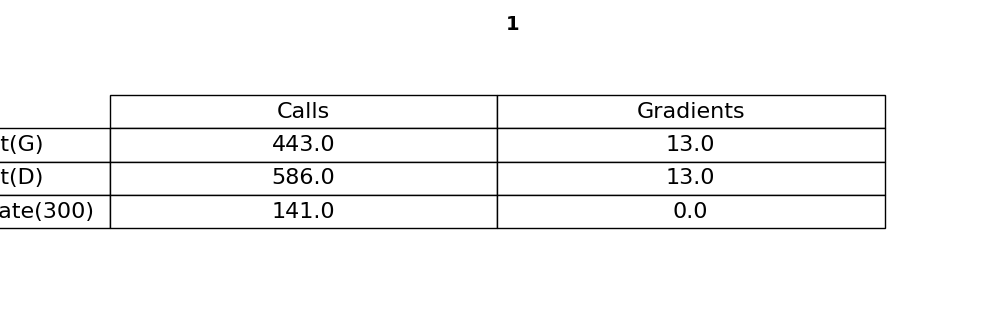

[[Point(coordinates=array([-2.80507496e+00,  3.13133232e+00,  7.72841744e-08])),
  Point(coordinates=array([-2.80506143e+00,  3.13132040e+00,  1.07331592e-07])),
  Point(coordinates=array([3.00025940e+00, 1.99966431e+00, 2.66373552e-06]))]]

In [25]:
base_mulltimodal = GradientLambdaOracul(lambda x, y: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2,
                                        lambda x, y: np.array([2 * (2 * x * (x ** 2 + y - 11) + x + y ** 2 - 7),
                                                               2 * (x ** 2 + 2 * y * (x + y ** 2 - 7) + y - 11)],
                                                              dtype=np.float64))

Tester.test([gradient_descent_golden, gradient_descent_dichotomy, coordinate_descent_3], [base_mulltimodal],
            start_point=np.array([-1000, -2000]), metrics=[CallCount(), GradientCount()],
            stop_condition=PrecisionCondition(0.001))


Ожидаемым образом, функции сходятся к оптимумам. В случае с base_multimodal - к глобальным (т.к. все являются таковыми), хотя и примечательно, что покоординатный спуск сошёлся к отличному от градиентных

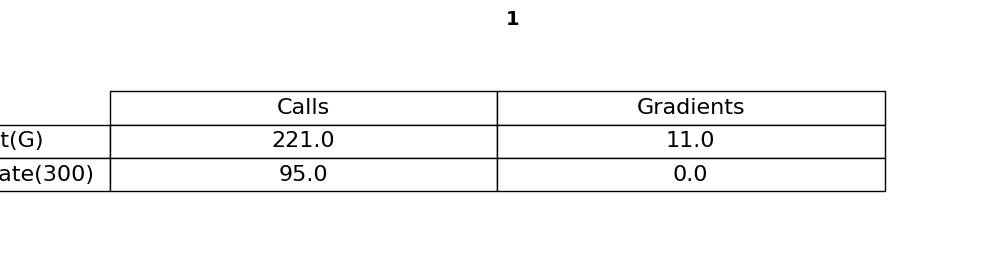

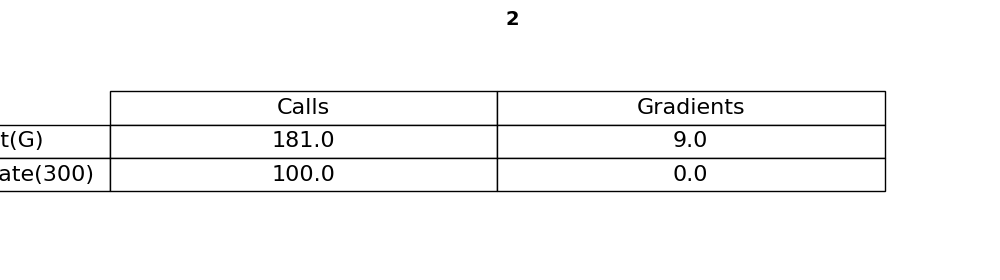

[[Point(coordinates=array([-2.80150761,  3.13051337, -0.00521739])),
  Point(coordinates=array([2.97851562, 2.00195312, 0.02138529]))],
 [Point(coordinates=array([-0.01765598, -0.03531196, -0.00506674])),
  Point(coordinates=array([ 0.04882812, -0.04882812,  0.00031148]))]]

In [22]:
Tester.test([gradient_descent_golden_1, coordinate_descent_1], [base_mulltimodal, base_test],
            start_point=np.array([-1000, -2000]), metrics=[CallCount(), GradientCount()],
            stop_condition=PrecisionCondition(0.1), noise=0.01)

Таким образом, хотя шум и влияет на вычисление минимума, не позволяя сойтись к точному значению, но зачастую позволяет обнаружить хотя бы радиус (Хотя в случае с покоординатным спуском или методом Нелдера-Мида возможны патологические ситуации, когда на плоской функции зашумление составляет больше изменения реальных значений), кроме того, очевидным образом, влияет на время сходимости. 

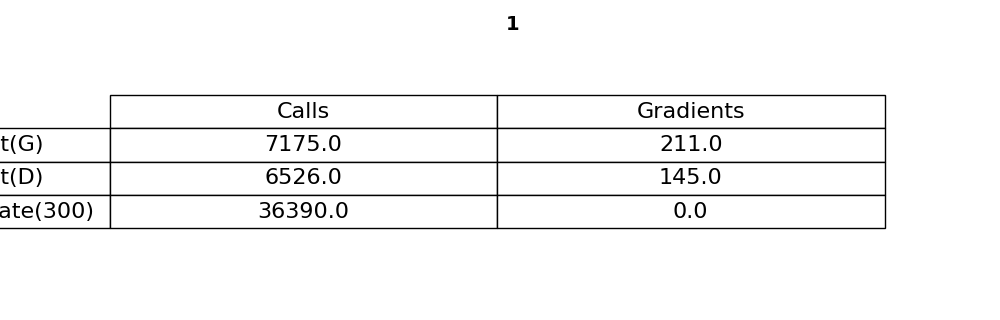

[[Point(coordinates=array([  1.00481901,   1.00691146,   1.0086003 ,   1.00986734,
           1.01074844,   1.0113147 ,   1.01165032,   1.01183361,
           1.01192587,   1.01196873,   1.01198713,   1.01199446,
           1.01199716,   1.0119981 ,   1.0119984 ,   1.01199849,
           1.01199851,   1.01199852,   1.01199852,   1.01199852,
           1.01199852,   1.01199852,   1.01199852,   1.01199852,
           1.01199852,   1.01199852,   1.01199852,   1.01199852,
           1.01199852,   1.01199852,   1.01199852,   1.01199852,
           1.01199852,   1.01199852,   1.01199852,   1.01199852,
           1.01199852,   1.01199852,   1.01199852,   1.01199852,
           1.01199852,   1.01199852,   1.01199852,   1.01199852,
           1.01199852,   1.01199852,   1.01199852,   1.01199852,
           1.01199852,   1.01199852,   1.01199852,   1.01199852,
           1.01199852,   1.01199852,   1.01199852,   1.01199852,
           1.01199852,   1.01199852,   1.01199852,   1.01199852,
       

In [24]:

def f(params: np.ndarray, i: int) -> float:
    return 100 * (params[i] - params[i - 1] ** 2) ** 2 + (1 - params[i - 1]) ** 2


def grad(params: np.ndarray):
    res = []
    for j in range(len(params)):
        if j == 0:
            res.append(-400 * params[0] * (params[1] - params[0] ** 2) - 2 * (1 - params[0]))
        elif j == len(params) - 1:
            res.append(200 * (params[j] - params[j - 1] ** 2))
        else:
            res.append(
                200 * (params[j] - params[j - 1] ** 2) - 400 * params[j] * (params[j + 1] - params[j] ** 2) - 2 * (
                        1 - params[j]))
    return np.array(res, dtype=np.float64)


oracul1 = MultiGradientLambdaOracul(f, grad, 20, start_sum=1)
oracul2 = MultiGradientLambdaOracul(f, grad, 100, start_sum=1)
Tester.test([gradient_descent_golden, gradient_descent_dichotomy, coordinate_descent_3],
            [oracul2], start_point=np.array([100 for _ in range(100)]),
            metrics=[CallCount(), GradientCount()], stop_condition=PrecisionCondition(0.001))

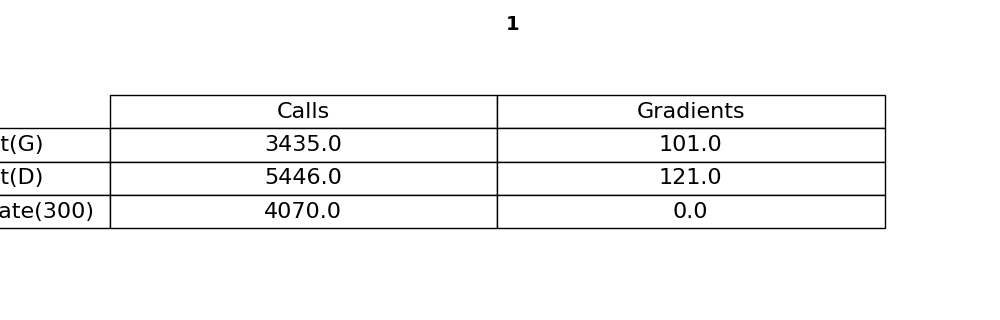

[[Point(coordinates=array([  1.01841889,   1.02548094,   1.03026352,   1.0331878 ,
           1.03482139,   1.03566443,   1.03608052,   1.03632018,
           1.03660365,   1.03728006,   1.0391547 ,   1.04419739,
           1.05706108,   1.08832561,   1.16193651,   1.33591057,
           1.77876621,   3.16421559,  10.01584002, 100.31901429,
          88.19306485])),
  Point(coordinates=array([  1.02070125,   1.02853977,   1.03375823,   1.03688734,
           1.03859858,   1.03946128,   1.03987471,   1.0401012 ,
           1.04035604,   1.04096702,   1.04269725,   1.04745202,
           1.05981592,   1.09035353,   1.16312716,   1.33640041,
           1.77888175,   3.16422757,  10.01593256, 100.31936802,
          88.56126309])),
  Point(coordinates=array([ 9.99450684e-01,  9.99450684e-01,  9.99450684e-01,  9.99450684e-01,
          9.98306274e-01,  9.97161865e-01,  9.94873047e-01,  9.89151001e-01,
          9.78851318e-01,  9.57107544e-01,  9.14764404e-01,  8.36944580e-01,
          6.9

In [39]:
Tester.test([gradient_descent_golden, gradient_descent_dichotomy, coordinate_descent_3],
            [oracul1], start_point=np.array([100 for _ in range(20)]),
            metrics=[CallCount(), GradientCount()], stop_condition=PrecisionCondition(0.001))

Хотя из-за сложности вида функции, методы и не сошлись к точному значению, при запросе продолженя итераций сходимость достигается (для методов градиентного спуска), что более примечательно - метод покоординатного спуска увеличивает число запрашиваемых значений куда быстрее с ростом числа измерений. И действительно, ддля методов градиентного спуска число измерений значения не имеет, в то время как для покоординатного спуска это означает большее число проверок значений. Метод Нелдера-Мида же вовсе превысил допустимое число итераций уже при 1- измерениях. Всё это позволяет сделать выводы о неприменимости методов покоординатного спуска и Нелдера-Мида для по-настоящему многомерных пространств
Так же, исходя из совокупности всех полученных результатов, хотя область применения методов градиентного спуска ии уже из-за необходимости иметь возможность вычисления градиента, в случае возможности применения на сложных или многомерных функциях, показывают они себя значительно лучше других расссмотренных методов, хотя в простых случаях алгоритм Нелдера-Мида показывает себя наилучшим образом